<a href="https://colab.research.google.com/github/oskorp/75lcOskorp/blob/main/Final_Year_Project(Omkar).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
print(tensorflow. __version__)

2.12.0


In [ ]:
BASE_DIR = '/content/drive/MyDrive/ProjectX'
WORKING_DIR = '/content/drive/MyDrive/ProjectX'

553467096/553467096 [==============================] - 24s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

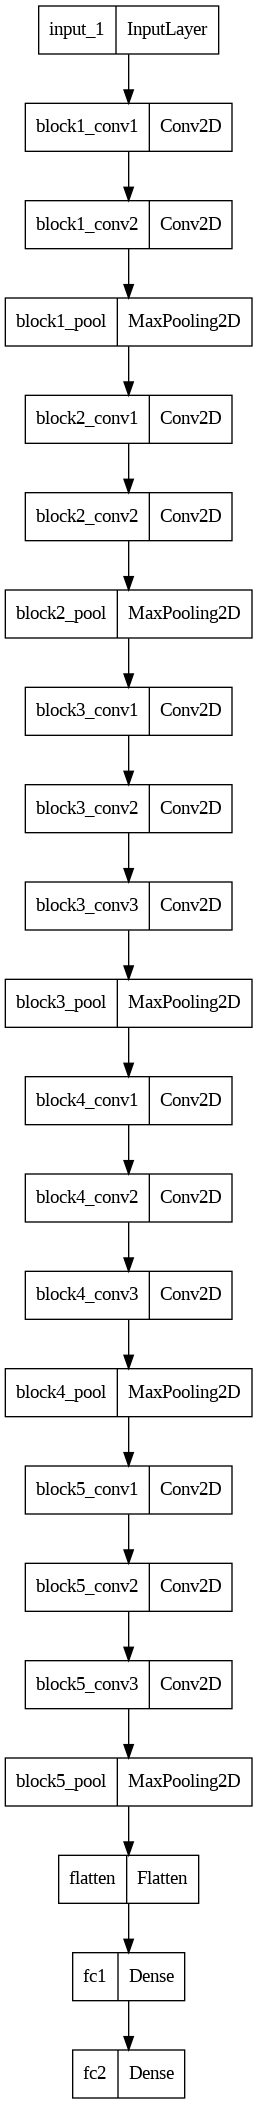

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())
plot_model(model)

In [ ]:
features = {}
directory = os.path.join(BASE_DIR, 'CNN-RNN Model PyNotes/Images')

for img_name in tqdm(os.listdir(directory)):

    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/394 [00:00<?, ?it/s]

In [ ]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/2275 [00:00<?, ?it/s]

In [ ]:
len(mapping)

391

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text


In [ ]:
clean(mapping)

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

1955

In [ ]:
all_captions[:10]

['startseq soldiers with binocular. endseq',
 'startseq soldiers camouflaging with grass endseq',
 'startseq soldiers defensing in harsh conditions endseq',
 'startseq soldiers under observations endseq',
 'startseq soldiers checking enemies endseq',
 'startseq soldier in mud endseq',
 'startseq soldier hiding for defense endseq',
 'startseq soldier hiding in muddy water endseq',
 'startseq soldier in marshy land endseq',
 'startseq surviving through swamp endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

387

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

13

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

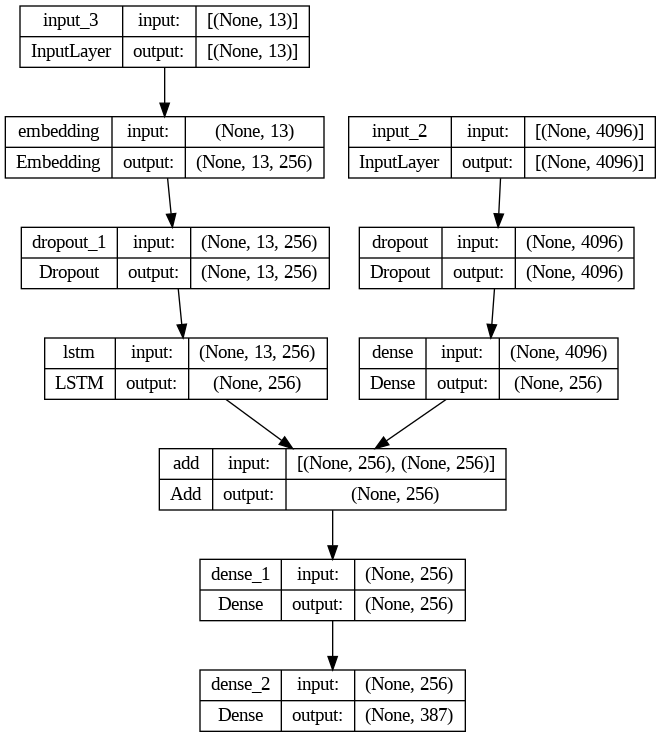

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
print(tensorflow. __version__)

2.12.0


In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

10/10 [==============================] - 1s 94ms/step - loss: 1.4382


In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "CNN-RNN Model PyNotes/Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [ ]:
generate_caption("image56.jpg")

In [ ]:
generate_caption("image69.jpg")

---------------------Actual---------------------
startseq miltarymen ready to shoot endseq
startseq soldier adjusting shooting focus endseq
startseq miltarymen holding gun endseq
startseq army ready for attack endseq
startseq enemy on gun point of the soldier endseq
--------------------Predicted--------------------
startseq soldier adjusting shooting focus endseq


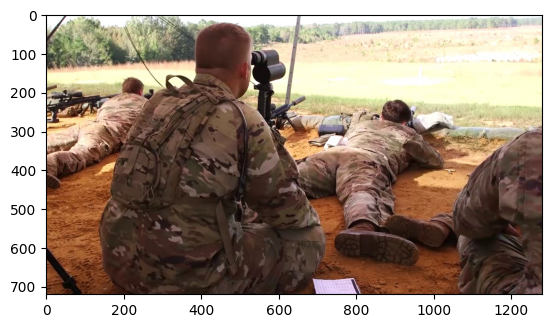

In [ ]:
generate_caption("image41.jpg")

---------------------Actual---------------------
startseq soldiers carry soldier on their shoulders endseq
startseq soldiers carry soldier on their shoulders are moving forward endseq
startseq soldiers carry soldier on their shoulders are running forward endseq
startseq soldiers carry soldier on their shoulders trying to move forward endseq
startseq soldiers are tired as they carry soldier on their shoulders endseq
--------------------Predicted--------------------
startseq soldier carry carry carry forward on their shoulders endseq


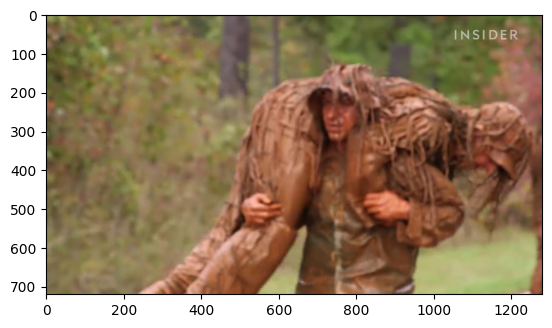

In [ ]:
generate_caption("image235.jpg")

---------------------Actual---------------------
startseq the soldier is saying something endseq
startseq the soldier is looking ahead endseq
startseq the soldier taking the lead endseq
startseq the soldier is instructing endseq
startseq the soldier in his base camp endseq
--------------------Predicted--------------------
startseq soldier is standing endseq


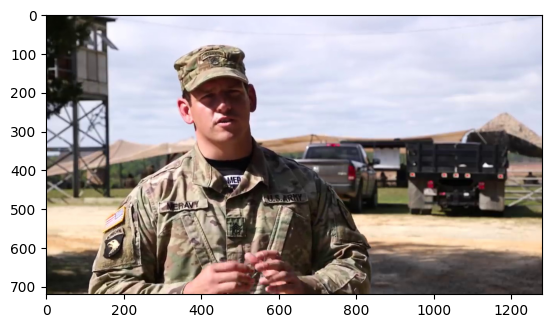

In [ ]:
generate_caption("image345.jpg")

In [ ]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs,
                  outputs=vgg_model.layers[-2].output)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/ProjectX/CNN-RNN Model PyNotes/Images/image106.jpg'
# load image

# img = Image.open(image_path)
# img.show()
image = load_img(image_path, target_size=(224, 224))
image.show()
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)


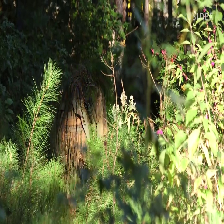

'startseq forest bushes endseq'

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/ProjectX/CNN-RNN Model PyNotes/Images/image117.jpg'
# load image

# img = Image.open(image_path)
# img.show()
image = load_img(image_path, target_size=(224, 224))
image.show()
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)


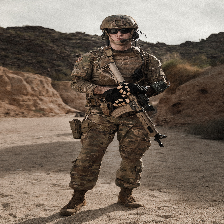

'startseq soldier is standing endseq'

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/ProjectX/demo images/jakob-owens-ZesUefCgYLc-unsplash.jpg'
# load image

# img = Image.open(image_path)
# img.show()
image = load_img(image_path, target_size=(224, 224))
image.show()
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)


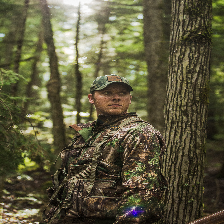

'startseq soldier is standing endseq'

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/ProjectX/demo images/brady-rogers-JC5owXHqPHw-unsplash.jpg'
# load image

# img = Image.open(image_path)
# img.show()
image = load_img(image_path, target_size=(224, 224))
image.show()
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

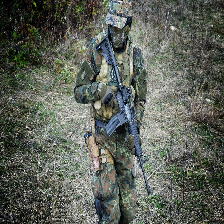

'startseq soldier is looking for the the the the the the the the the'

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/ProjectX/demo images/daniel-balaure-n2e_XAPtMic-unsplash.jpg'
# load image

# img = Image.open(image_path)
# img.show()
image = load_img(image_path, target_size=(224, 224))
image.show()
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

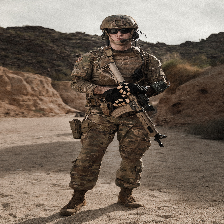

'startseq soldier is standing endseq'

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/ProjectX/demo images/jakob-owens-ZesUefCgYLc-unsplash.jpg'
# load image

# img = Image.open(image_path)
# img.show()
image = load_img(image_path, target_size=(224, 224))
image.show()
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

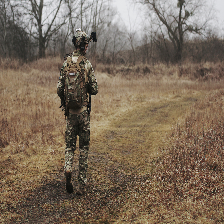

'startseq soldier is standing endseq'

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/ProjectX/demo images/specna-arms-Um9WPLvWV_M-unsplash.jpg'
# load image

# img = Image.open(image_path)
# img.show()
image = load_img(image_path, target_size=(224, 224))
image.show()
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

In [ ]:
print(newGenerate('/content/drive/MyDrive/ProjectX/demo images/jakob-owens-ZesUefCgYLc-unsplash.jpg'))

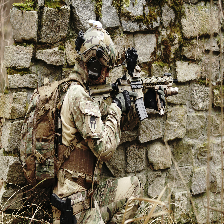

'startseq soldier is looking for the target endseq'

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/ProjectX/demo images/specna-arms-kVVKHGNgsAw-unsplash.jpg'
# load image

# img = Image.open(image_path)
# img.show()
image = load_img(image_path, target_size=(224, 224))
image.show()
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

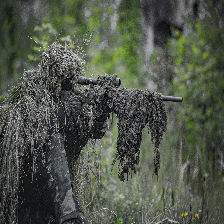

'startseq the soldier is looking in the the the endseq'

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/ProjectX/demo images/specna-arms-we11d4bX-UE-unsplash.jpg'
# load image

# img = Image.open(image_path)
# img.show()
image = load_img(image_path, target_size=(224, 224))
image.show()
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)